In [29]:
!pip install psycopg2 requests pandas numpy scikit-learn matplotlib joblib Flask waitress

In [ ]:
import psycopg2
table_ver = 3
# Connect to PostgreSQL
conn = psycopg2.connect(
    host="localhost",
    database="mydatabase",
    user="myuser",
    password="mypassword"
)
cur = conn.cursor()

Test train a simple ML Model to ensure data processing pipeline is right.  
Also evaluate the importance of each feature quickly using RandomForestRegressor

C:\Users\guang\AppData\Local\Temp\ipykernel_67104\3211474891.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Price - Mean: 1241470.48, Std: 209198.69
Root Mean Squared Error (Unnormalized): 171123.40582164674
R-squared Score: -2.36524034126669

Feature Importance:
                      feature  importance
1  months_since_contract_date    0.479290
2  months_since_commence_date    0.246711
3                        area    0.223014
4                 floor_range    0.050986
0              market_segment    0.000000


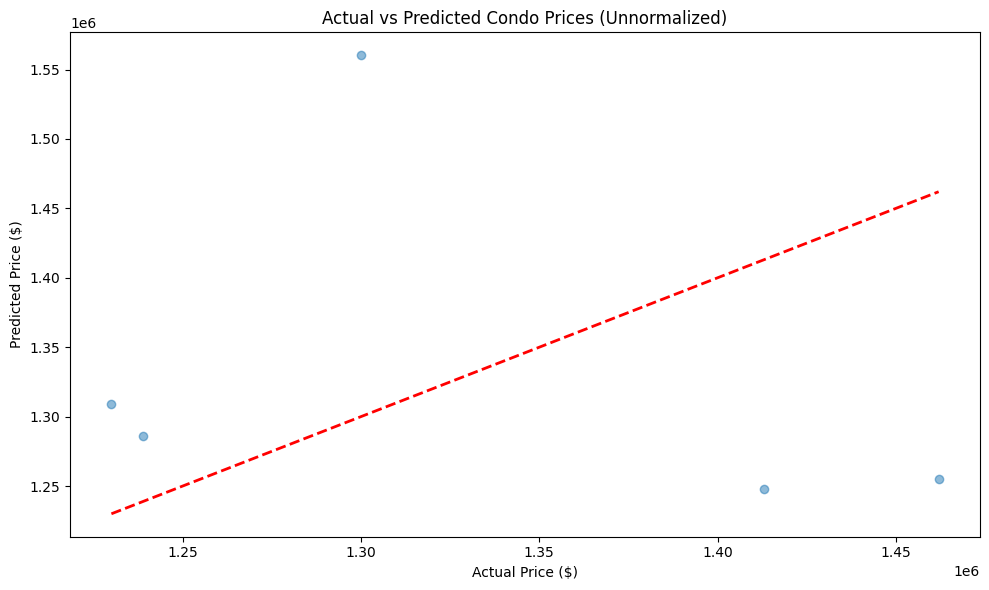

'joblib.dump(rf_model, \'condo_price_predictor.joblib\')\njoblib.dump(le_market_segment, \'le_market_segment.joblib\')\njoblib.dump(le_floor_range, \'le_floor_range.joblib\')\njoblib.dump((price_mean, price_std), \'normalization_params.joblib\')  # Save mean and std\nprint("Model and encoders saved")\n\n'

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# 1. Fetch data from the database
query = f"""
SELECT market_segment, months_since_contract_date, months_since_commence_date, 
       area, price, floor_range
FROM transactions_v{table_ver}
"""
df = pd.read_sql_query(query, conn)

# 2. Preprocess the data
# Create separate LabelEncoders for each categorical variable
le_market_segment = LabelEncoder()
le_floor_range = LabelEncoder()

# Fit and transform each categorical column
df['market_segment'] = le_market_segment.fit_transform(df['market_segment'])
df['floor_range'] = le_floor_range.fit_transform(df['floor_range'])

# Engineer new feature
# df['age_of_property_at_transaction_date'] = df['months_since_commence_date'] - df['months_since_contract_date']


# 2. Preprocess the data
# Calculate mean and std for 'price'
price_mean, price_std = df['price'].mean(), df['price'].std()
print(f"Price - Mean: {price_mean:.2f}, Std: {price_std:.2f}")

# Normalize 'price'
df['price_normalized'] = (df['price'] - price_mean) / price_std

# Split features and target
X = df.drop(['price', 'price_normalized'], axis=1)
y = df['price_normalized']

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. Make predictions
y_pred_normalized = rf_model.predict(X_test)

# Denormalize predictions and actual values
y_pred = y_pred_normalized * price_std + price_mean
y_test_denormalized = y_test * price_std + price_mean

# 6. Evaluate the model
mse = mean_squared_error(y_test_denormalized, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_denormalized, y_pred)


print(f"Root Mean Squared Error (Unnormalized): {rmse}")
print(f"R-squared Score: {r2}")

# 7. Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# 8. Visualize predictions vs actual (Unnormalized)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_denormalized, y_pred, alpha=0.5)
plt.plot([y_test_denormalized.min(), y_test_denormalized.max()], 
         [y_test_denormalized.min(), y_test_denormalized.max()], 'r--', lw=2)
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs Predicted Condo Prices (Unnormalized)")
plt.tight_layout()
plt.show()

# 9. This is just a test train to verify processing pipeline is right.
# Dont save this as it is not optimal, proceed to fine-tune it in the next cell
'''joblib.dump(rf_model, 'condo_price_predictor.joblib')
joblib.dump(le_market_segment, 'le_market_segment.joblib')
joblib.dump(le_floor_range, 'le_floor_range.joblib')
joblib.dump((price_mean, price_std), 'normalization_params.joblib')  # Save mean and std
print("Model and encoders saved")

'''



In [7]:
df

,market_segment,months_since_contract_date,months_since_commence_date,area,price,floor_range,price_normalized
0,0,33,116,107,1238880,0,-0.012383
1,0,32,116,100,1230000,2,-0.054831
2,0,26,116,107,1330000,2,0.423184
3,0,53,128,97,960000,1,-1.345470
4,0,46,128,97,1020000,1,-1.058661
5,0,40,128,84,920000,0,-1.536675
6,0,55,140,93,885000,0,-1.703980
7,0,15,80,124,1803000,0,2.684192
8,0,2,80,78,1300000,3,0.279780
9,0,52,140,124,1250000,1,0.040772


Define list of models, automate fine-tunning by GridSearch

Price - Mean: 1241470.48, Std: 209198.69
Best model: {'regressor': ElasticNet(), 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.1}
Root Mean Squared Error (Unnormalized): $123413.99
R-squared Score: -0.7504


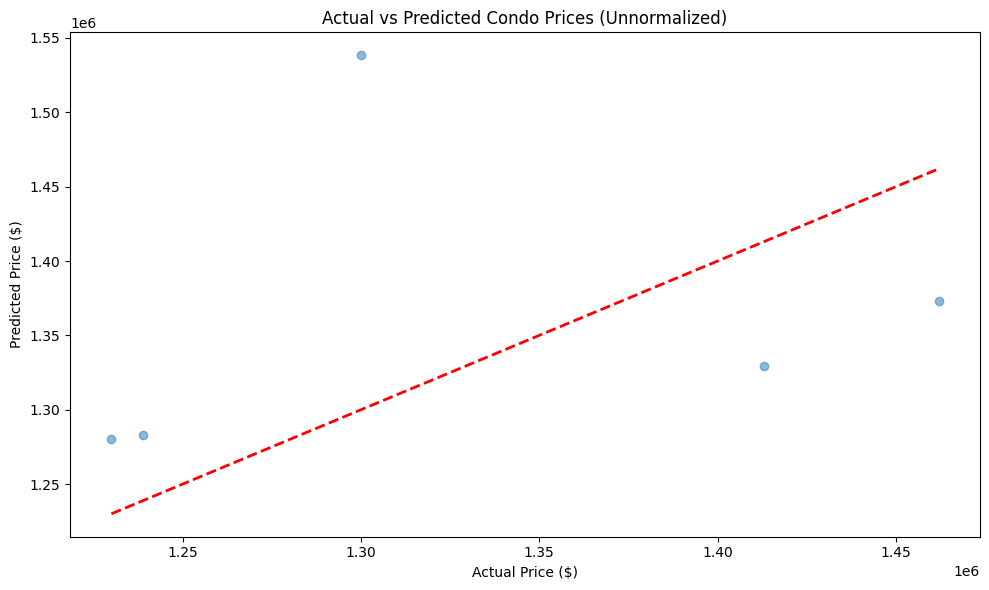

Best model and normalization parameters saved


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import joblib

# ... (keep your data loading and preprocessing steps the same)

# Calculate mean and std for 'price'
price_mean, price_std = df['price'].mean(), df['price'].std()

print(f"Price - Mean: {price_mean:.2f}, Std: {price_std:.2f}")

# Normalize 'price'
df['price_normalized'] = (df['price'] - price_mean) / price_std

# Split features and target
X = df.drop(['price', 'price_normalized'], axis=1)
y = df['price_normalized']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

# Define the models and their hyperparameters to search
param_grid = [
    {
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    },
    {
        'regressor': [ElasticNet()],
        'regressor__alpha': [0.1, 1.0, 10.0],
        'regressor__l1_ratio': [0.1, 0.5, 0.9]
    },
    {
        'regressor': [SVR()],
        'regressor__C': [0.1, 1.0, 10.0],
        'regressor__kernel': ['rbf', 'linear']
    }
]

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred_normalized = best_model.predict(X_test)

# Denormalize predictions and actual values
y_pred = y_pred_normalized * price_std + price_mean
y_test_denormalized = y_test * price_std + price_mean

# Evaluate the model
mse = mean_squared_error(y_test_denormalized, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_denormalized, y_pred)

print(f"Best model: {grid_search.best_params_}")
print(f"Root Mean Squared Error (Unnormalized): ${rmse:.2f}")
print(f"R-squared Score: {r2:.4f}")

# Feature importance (if the best model is RandomForestRegressor)
if isinstance(best_model.named_steps['regressor'], RandomForestRegressor):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.named_steps['regressor'].feature_importances_
    }).sort_values('importance', ascending=False)
    print("\nFeature Importance:")
    print(feature_importance)

    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
    plt.xlabel("Importance")
    plt.title("Feature Importance")
    plt.show()


# 8. Visualize predictions vs actual (Unnormalized)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_denormalized, y_pred, alpha=0.5)
plt.plot([y_test_denormalized.min(), y_test_denormalized.max()], 
         [y_test_denormalized.min(), y_test_denormalized.max()], 'r--', lw=2)
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs Predicted Condo Prices (Unnormalized)")
plt.tight_layout()
plt.show()

# Save the best model
joblib.dump(best_model, 'best_condo_price_predictor.joblib')
joblib.dump(le_market_segment, 'le_market_segment.joblib')
joblib.dump(le_floor_range, 'le_floor_range.joblib')
joblib.dump((price_mean, price_std), 'normalization_params.joblib')
print("Best model and normalization parameters saved")

Test inference with a fake data

In [13]:
 # Load the saved LabelEncoders
le_market_segment = joblib.load('le_market_segment.joblib')
le_floor_range = joblib.load('le_floor_range.joblib')

# Print valid attributes of the label encoders
print("Market Segment Classes:", le_market_segment.classes_)
print("Floor Range Classes:", le_floor_range.classes_)


# Load models and params
model = joblib.load('best_condo_price_predictor.joblib')
price_mean, price_std = joblib.load('normalization_params.joblib')
    
def prepare_data_for_inference(market_segment, months_since_contract_date, months_since_commence_date, 
                               area, floor_range):
    
    # Create a dictionary with the input data
    data = {
        'market_segment': [le_market_segment.transform([market_segment])[0]],
        'months_since_contract_date': [months_since_contract_date],
        'months_since_commence_date': [months_since_commence_date],
        'area': [area],
        'floor_range': [le_floor_range.transform([floor_range])[0]],
    }
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Add the engineered feature
    # df['age_of_property_at_transaction_date'] = df['months_since_commence_date'] - df['months_since_contract_date']
    
    return df

# Example usage for inference, change fake data values to test
new_data = prepare_data_for_inference(market_segment='OCR', 
                                      months_since_contract_date=55, 
                                      months_since_commence_date=120, 
                                      area=155, 
                                      floor_range='11-15')

normalized_predicted_price = model.predict(new_data)
predicted_price = normalized_predicted_price * price_std + price_mean
print(f"Predicted price: ${predicted_price[0]:,.2f}")

Market Segment Classes: ['OCR']
Floor Range Classes: ['01-05' '06-10' '11-15' '16-20']
Predicted price: $1,524,971.74


Run simple flask API on local machine


In [22]:
from flask import Flask

app = Flask(__name__)

@app.route('/')
def hello():
    return "Hello, World!"

if __name__ == '__main__':
    app.run(port=5001)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit
127.0.0.1 - - [14/Sep/2024 18:43:48] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Sep/2024 18:43:48] "GET /favicon.ico HTTP/1.1" 404 -


Develop and run flask API on local machine


In [30]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)

# Load the saved LabelEncoders and model
le_market_segment = joblib.load('le_market_segment.joblib')
le_floor_range = joblib.load('le_floor_range.joblib')
model = joblib.load('best_condo_price_predictor.joblib')
price_mean, price_std = joblib.load('normalization_params.joblib')

def prepare_data_for_inference(market_segment, months_since_contract_date, months_since_commence_date, 
                               area, floor_range):
    data = {
        'market_segment': [le_market_segment.transform([market_segment])[0]],
        'months_since_contract_date': [months_since_contract_date],
        'months_since_commence_date': [months_since_commence_date],
        'area': [area],
        'floor_range': [le_floor_range.transform([floor_range])[0]],
    }
    return pd.DataFrame(data)

@app.route('/predict', methods=['POST'])
def predict():
    # Get JSON data from request
    data = request.json
    market_segment = data['market_segment']
    months_since_contract_date = data['months_since_contract_date']
    months_since_commence_date = data['months_since_commence_date']
    area = data['area']
    floor_range = data['floor_range']
    
    # Prepare data for inference
    new_data = prepare_data_for_inference(market_segment, months_since_contract_date, 
                                          months_since_commence_date, area, floor_range)
    
    # Make prediction
    normalized_predicted_price = model.predict(new_data)
    predicted_price = normalized_predicted_price * price_std + price_mean
    
    return jsonify({'predicted_price': predicted_price[0]})

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


Run python flask_app.py to run the flask API and then run the below code to test the API


In [37]:
import requests
# Sample data for the request
data = {
    "market_segment": "OCR",
    "months_since_contract_date": 55,
    "months_since_commence_date": 120,
    "area": 995,
    "floor_range": "11-15"
}

# Make a POST request to the /predict endpoint
response = requests.post('http://127.0.0.1:5000/predict', json=data)

# Print the response
print(response.json())

{'predicted_price': 8598172.454542061}
